In [116]:
import pandas as pd
import seaborn as sns

from matplotlib import ticker as tkr
from functools import partial

In [99]:
df = pd.read_csv('4pda_dump.csv', parse_dates=['date_published'])

Ok. Seaborn doesn't like dates.
Lets add **seconds_since_first** series

In [125]:
def time_delta_seconds(time_stamp, from_date):
    delta = time_stamp - from_date
    return delta.days * 24 * 60 * 60 + delta.seconds

from_date = df.date_published.min()
df['seconds_since_first'] = df.date_published.apply(
    # partial is a cool trick to pass reference to 
    # a function with preset of kwargs
    partial(time_delta_seconds, from_date=from_date)
)

df[['date_published', 'seconds_since_first']].head()

,date_published,seconds_since_first
0,2017-01-26 08:00:00,8704500
1,2017-01-26 07:00:00,8700900
2,2017-01-26 06:30:00,8699100
3,2017-01-26 06:00:00,8697300
4,2017-01-26 05:00:00,8693700


In [126]:
df[['date_published', 'seconds_since_first']].tail()

,date_published,seconds_since_first
3055,2016-10-17 15:43:00,5880
3056,2016-10-17 15:07:42,3762
3057,2016-10-17 14:48:00,2580
3058,2016-10-17 14:33:00,1680
3059,2016-10-17 14:05:00,0


Also lets add cum_sum field. So each new article will increment cumsum counter by 1 starting from 1.

In [128]:
df['cum_sum'] = range(df.shape[0], 0, -1)
df[['date_published', 'cum_sum']].tail(5)


,date_published,cum_sum
3055,2016-10-17 15:43:00,5
3056,2016-10-17 15:07:42,4
3057,2016-10-17 14:48:00,3
3058,2016-10-17 14:33:00,2
3059,2016-10-17 14:05:00,1


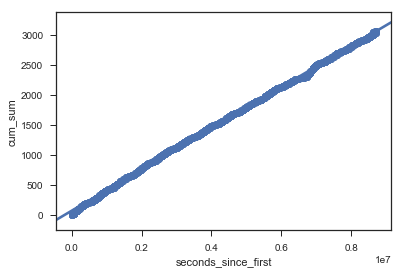

In [130]:
%matplotlib inline

# regression plot
sns.regplot(x='seconds_since_first', y='cum_sum', data=df)

To much data that looks reguar. No strange behaviour no outliers.

**Lets build 10 plots for 10 date ranges Yay**

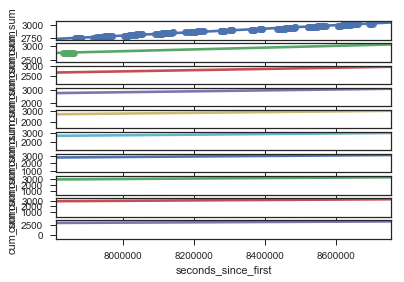

In [132]:
partition_amount = 10
partition = df_len // partition_amount

start = 0
slices = []
df_len = len(df.index)

for i in range(partition, df_len + 1, partition):
    """
    slice(0, 305, None)
    slice(305, 611, None)
    slice(611, 917, None)
    slice(917, 1223, None)
    slice(1223, 1529, None)
    slice(1529, 1835, None)
    slice(1835, 2141, None)
    slice(2141, 2447, None)
    slice(2447, 2753, None)
    slice(2753, 3059, None)
    """
    slices.append(slice(start, i - 1))
    start = i - 1

f, ax_list = plt.subplots(partition_amount, sharex='all')

for _slice, ax_n in zip(slices, ax_list):
    sns.regplot(
        x='seconds_since_first',
        y='cum_sum',
        data=df[_slice],
        ax=ax_n
    )


**Ok that looks even uglier**



Lets do some plots that based on how information appears **during the day**

In [133]:
df['extra_counter'] = 1

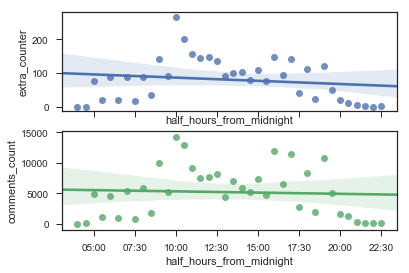

In [138]:
df['half_hours_from_midnight'] = df.date_published.apply(lambda x: (x.hour * 60 + x.minute)//30)
# dtd aka during the day
dtd_grouped_data = df.groupby(['half_hours_from_midnight'])
dtd_sum_data = dtd_grouped_data.sum().reset_index()

f, (ax1, ax2) = plt.subplots(2, sharex='all')
sns.regplot(x='half_hours_from_midnight', y='extra_counter', data=dtd_sum_data, ax=ax1)
sns.regplot(x='half_hours_from_midnight', y='comments_count', data=dtd_sum_data, ax=ax2)
ax2.xaxis.set_major_formatter(tkr.FuncFormatter(lambda x, y: '%02d:%02d' % divmod(x * 30, 60)))

Looks good.

peak is around 10am and from 8pm it's slowly going down


**Lets build same depending on Weekday**


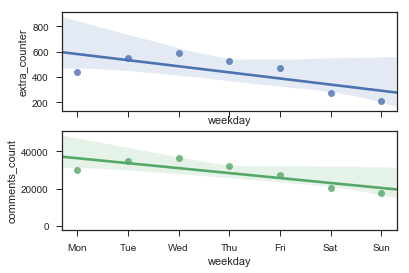

In [136]:
df['weekday'] = df.date_published.apply(lambda x: x.weekday())
week_grouped_data = df.groupby(['half_hours_from_midnight'])
week_sum_data = week_grouped_data.sum().reset_index()
f, (ax1, ax2) = plt.subplots(2, sharex='all')
sns.regplot(x='weekday', y='extra_counter', data=weekly_sum_data, ax=ax1)
sns.regplot(x='weekday', y='comments_count', data=weekly_sum_data, ax=ax2)

day_abbr = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'Mon', 'Tue']
ax2.xaxis.set_major_formatter(tkr.FuncFormatter(lambda x, y: day_abbr[int(x)]))


Awesome. Those who compare 2 plots for comments and articles frequency might see a dependency there

Lets check it out

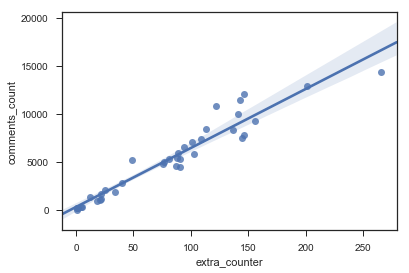

In [137]:
sns.regplot(x='extra_counter', y='comments_count', data=dtd_sum_data)


So eventualy comment count are highly correlated with article count.

That might say that people who visiting the portal are commenting articles evenly and to attract more comments simply increase amount of articles daily 